# How the Climate in Arctic has Changed Over Time

In this notebook we will analyze over 30 years of temperature data in Arctic using __[NASA MERRA2 data](http://data.planetos.com/datasets/nasa_merra2_global)__. We also compare average temperature with this year observational data which we get from __[NOAA RBSN dataset](http://data.planetos.com/datasets/noaa_rbsn_timeseries)__.

__[NASA MERRA2 dataset](http://data.planetos.com/datasets/nasa_merra2_global)__ is reanalysis dataset that provides data beginning in 1980.

So, we will do the following:

1) use the Planet OS package API to fetch data;

2) see mean annual temperature in Arctic

3) plot number of days in year when temperature exceeds 5 °C in Arctic;

4) plot observation data from beginning of this year (2019)

The reason I don't specify the location is that we want you to feel free changing it. You can simply choose your favorite RBSN station and change `station` few cells below. There's also a link where you can see all the RBSN stations on the map below. 

API documentation is available at http://docs.planetos.com. If you have questions or comments, join the Planet OS Slack community to chat with our development team. For general information on usage of IPython/Jupyter and Matplotlib, please refer to their corresponding documentation. https://ipython.org/ and http://matplotlib.org/

__This Notebook is running on Python3.__

In [16]:
%matplotlib inline
import numpy as np
from dh_py_access import package_api
import dh_py_access.lib.datahub as datahub
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import datetime
from po_data_process import make_comparison_plot, make_plot, make_anomalies_plot,read_data_to_json,compare_observations_analysis_mean
import warnings
warnings.filterwarnings('ignore')
import matplotlib
print (matplotlib.__version__)

3.0.3


<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [2]:
server = 'api.planetos.com'
API_key = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'
version = 'v1'

At first, we need to define the dataset name and variables we want to use.

In [3]:
dh=datahub.datahub(server,version,API_key)
dataset='nasa_merra2_global_v2'
variable_names = 'T2MMEAN,T2MMAX,T2MMIN'
time_start = '1980-01-01T00:00:00'
area_name = 'Bering_Strait'

In this part we define the RBSN dataset key as we would like to use observational data from stations as well. Also, we define station id - you can see different station id's on  __[the RBSN detail page map](http://data.planetos.com/datasets/noaa_rbsn_timeseries)__. At this point, we are choosing a station near Bering Strait. Only requirement would be that the station should locate somewhere near Arctic. However, graphs are still working on other places as well. 

In [4]:
dataset1 = 'noaa_rbsn_timeseries'
station = '25399' #
time_start_synop = '2019-01-01T00:00:00'
time_end = '2019-02-28T23:00:00'#datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%dT%H:%M:%S')
variable = 'temperature'
link = 'https://api.planetos.com/v1/datasets/noaa_rbsn_timeseries/stations/{0}?origin=dataset-details&apikey={1}&count=1000&time_start={2}&time_end={3}&var={4},lat,lon'.format(station,API_key,time_start_synop,time_end,variable)
data = read_data_to_json(link)

Now we read in station data and from it we define longitude latitude values to get data from the same location using MERRA2 dataset as well. 

In [5]:
time_synop = [datetime.datetime.strptime(n['axes']['time'],'%Y-%m-%dT%H:%M:%S') for n in data['entries']][:-54]
temp_synop = [n['data']['temperature'] for n in data['entries']][:-54]
latitude = data['entries'][0]['axes']['latitude']
longitude = data['entries'][0]['axes']['longitude']

For starters, using Basemap we created a map of the Arctic region and we mark chosen location with a red dot.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


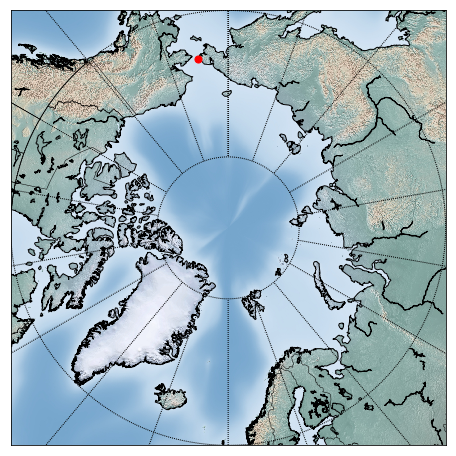

In [6]:
plt.figure(figsize=(10,8))
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
x,y = m(longitude,latitude)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.shadedrelief()
m.scatter(x,y,50,marker='o',color='red',zorder=4)
plt.show()

### Download the data with package API

1. Create package objects
2. Send commands for the package creation
3. Download the package files

_Note that this package has over a 30 years of data and downloading it might take some time_

In [7]:
package = package_api.package_api(dh,dataset,variable_names,longitude,longitude,latitude,latitude,time_start,time_end,area_name=area_name)

In [8]:
package.make_package()

Package exists


In [9]:
package.download_package()

File already downloaded


## Work with downloaded files

We start by opening the files with xarray. We also convert Kelvins to Celsius degrees. 

In [10]:
dd1 = xr.open_dataset(package.local_file_name)
dd1['T2MMEAN'] = dd1['T2MMEAN'] -272.15

First, we find yearly mean temperatures and then calculate overall mean temperature. 

In [11]:
yearly_tmean = dd1.T2MMEAN.resample(time="1AS").mean('time')[:,0,0]
tmean_mean = yearly_tmean.mean(axis=0)
print ('Overall mean for tmean is ' + str("%.2f" % tmean_mean.values))

Overall mean for tmean is -4.12


Now it is time to plot mean annual temperature in Arctic. We also marked overall average for 1980-2019 with a red dotted line. The green line marks a trend. 

The other significant thing we can see from looking at the plot is that the temperatures have been rising over the years. The small anomalies are normal, while after 2014 the temperature hasn't dropped below average at all. That's an unusual pattern. For example, in 2004 and 2014 the temperature was over 2 degrees above overall average, while in 2017 temperature have been more than 3 °C degree over the average. 

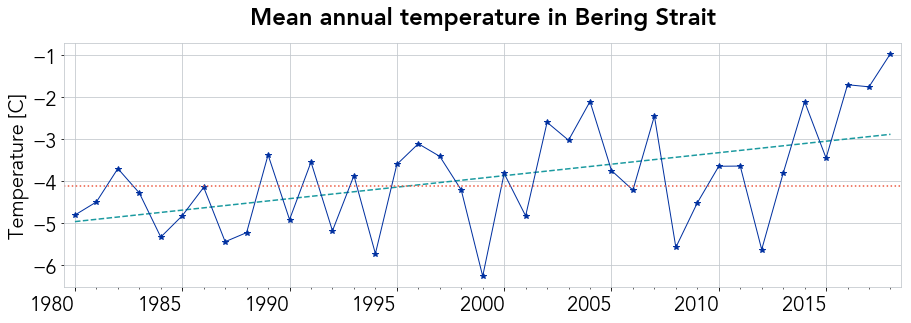

In [12]:
make_plot(yearly_tmean.loc[yearly_tmean['time.year'] < 2019],dataset,'Mean annual temperature in ' + ' '.join(area_name.split('_')),ylabel = 'Temperature [C]',compare_line = tmean_mean.values,trend=True)

Here we show number of days in a year when temperature exceeds 10 °C. Here we can see that year 2004 stands out pretty well. 

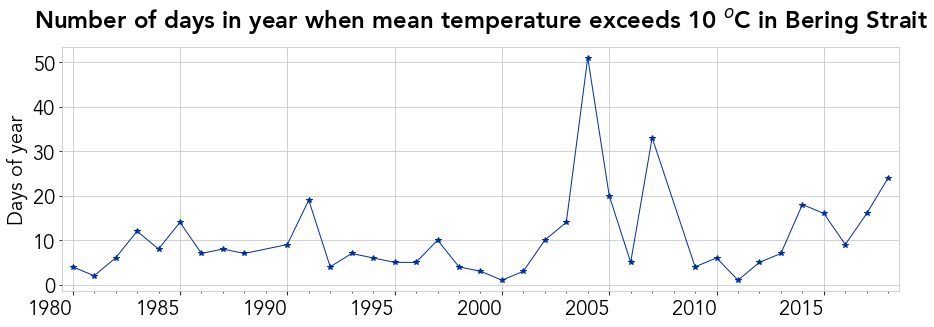

Yearly average days when temperature exceeds 10 C is 10.4


In [13]:
daily_data = dd1.T2MMEAN[:,0,0]
make_plot(daily_data[np.where(daily_data.values > 10)].groupby('time.year').count(),dataset,'Number of days in year when mean temperature exceeds 10 $^o$C in ' + ' '.join(area_name.split('_')),ylabel = 'Days of year')
print ('Yearly average days when temperature exceeds 10 C is ' + str("%.1f" % daily_data[np.where(daily_data.values > 10)].groupby('time.year').count().mean().values))

In [14]:
data_jan = dd1.sel(time=dd1['time.month']<3)
jan_mean_temp = np.mean(data_jan.T2MMEAN)

Last, we will compare observational data from the beginning of this year with the overall January and February mean.                    

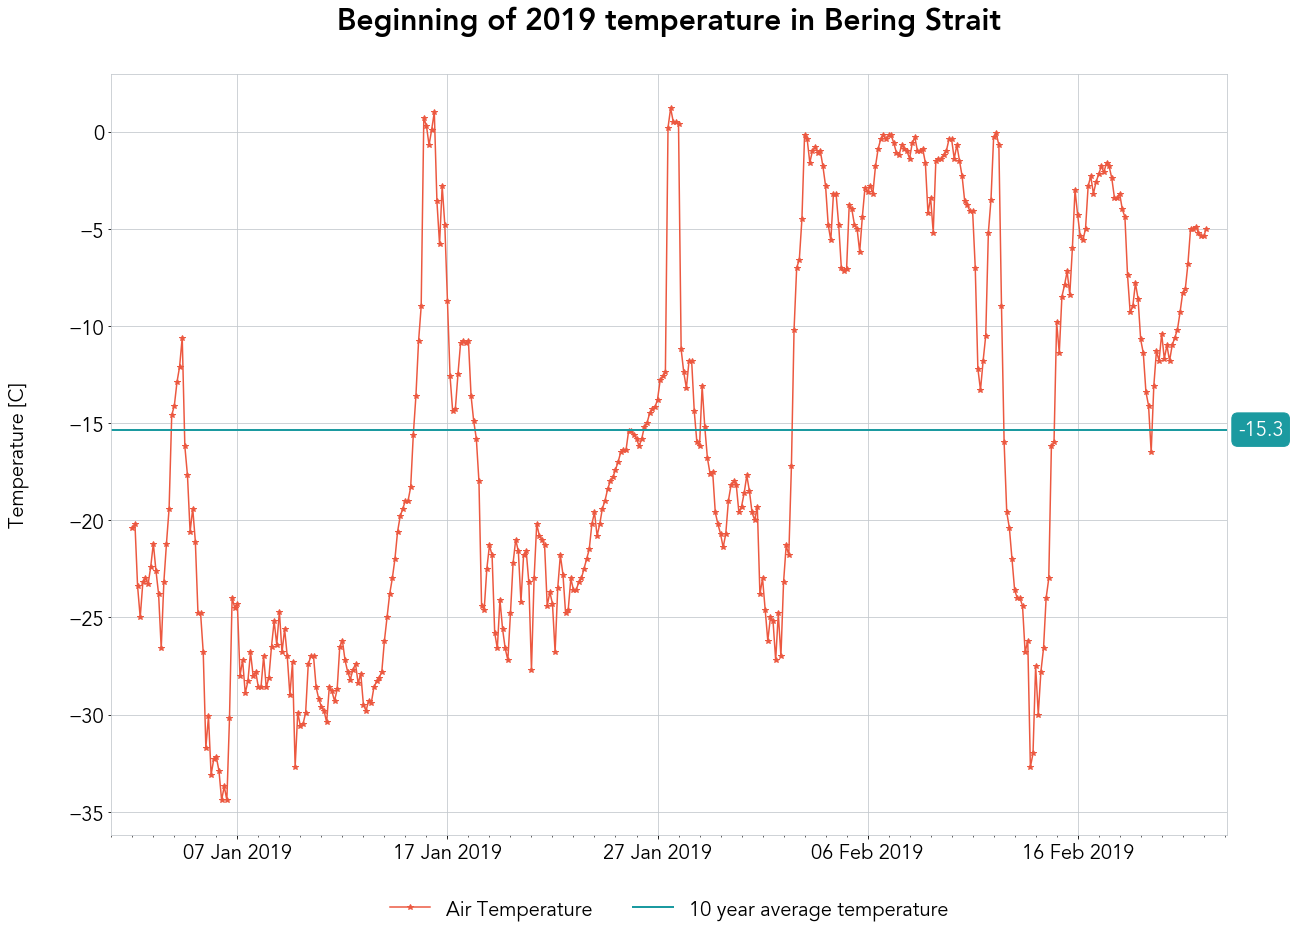

In [15]:
compare_observations_analysis_mean(time_synop,temp_synop,'Air Temperature',jan_mean_temp.values,\
                                   '10 year average temperature','Beginning of 2019 temperature in ' + ' '.join(area_name.split('_')),\
                                   'january_feb_' + area_name + '.png')